In [1]:
import pymc3 as pm
import theano
import theano.tensor as tt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import corner
import exoplanet as xo
from exoplanet.distributions import Angle

import astropy.units as u
from astropy import constants
from astropy.time import Time

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi / 180.0
rad_2_deg = 180 / np.pi
yr = 365.25


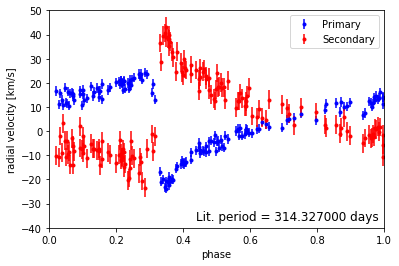

In [3]:
# Read RV data
RV_Ba = pd.read_csv('RV_Ba.csv')
RV_Bb = pd.read_csv('RV_Bb.csv')

t = RV_Ba['HJD'].to_numpy()
rva = RV_Ba['Ba'].to_numpy()
rva_err = RV_Ba['Ba_err'].to_numpy()

rvb = RV_Bb['Bb'].to_numpy()
rvb_err = RV_Bb['Bb_err'].to_numpy()

# Plot the observations "folded" on the published period:
# Boden et al. (2005) arXiv:astro-ph/0508331
lit_period = 314.327

# Primary
plt.errorbar(
    (t % lit_period) / lit_period, rva, yerr=rva_err, fmt=".b", capsize=0, label="Primary"
)
# Secondaty
plt.errorbar(
    (t % lit_period) / lit_period, rvb, yerr=rvb_err, fmt=".r", capsize=0, label="Secondary"
)

plt.xlim(0, 1)
plt.ylim(-40, 50)
plt.annotate(
    "Lit. period = {0:.6f} days".format(lit_period),
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-5, 5),
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10)

plt.ylabel("radial velocity [km/s]")
_ = plt.xlabel("phase")

In [4]:
#Define the model to fit SB2

with pm.Model() as model:

    # Parameters
    logK1 = pm.Uniform(
        "logK1",
        lower=0,
        upper=np.log(100),
        testval=np.log(0.5 * (np.max(rva) - np.min(rva))),
    )
    
    logK2 = pm.Uniform(
        "logK2",
        lower=0,
        upper=np.log(100),
        testval=np.log(0.5 * (np.max(rvb) - np.min(rvb))),
    )
    
    logP = pm.Uniform(
        "logP", lower=np.log(100), upper=np.log(500), testval=np.log(lit_period)
    )
    
    phi = pm.Uniform("phi", lower=0, upper=2 * np.pi, testval=0.1)

    # Parameterize the eccentricity using:
    #  h = sqrt(e) * sin(w)
    #  k = sqrt(e) * cos(w)
    hk = xo.UnitDisk("hk", testval=np.array([-0.83, 0.29]))
    e = pm.Deterministic("e", hk[0] ** 2 + hk[1] ** 2)
    w = pm.Deterministic("w", tt.arctan2(hk[1], hk[0]))

    rv0 = pm.Normal("rv0", mu=0.0, sd=10.0, testval=0.0)
    rvtrend = pm.Normal("rvtrend", mu=0.0, sd=10.0, testval=0.0)

    # Deterministic transformations
    
    #Primary
    K1 = pm.Deterministic("K1", tt.exp(logK1))
    cosw = tt.cos(w)
    sinw = tt.sin(w)
    
    # Secondary
    K2 = pm.Deterministic("K2", tt.exp(logK2))
    coswb = tt.cos(w+np.pi)
    sinwb = tt.sin(w+np.pi)
    
    n = 2 * np.pi * tt.exp(-logP)
    P = pm.Deterministic("P", tt.exp(logP))
    t0 = pm.Deterministic("T0", (phi + w) / n)

    # The RV model
    bkg = pm.Deterministic("bkg", rv0 + rvtrend * t / 365.25)
    M = n * t - (phi + w)

    # This is the line that uses the custom Kepler solver
    f = xo.orbits.get_true_anomaly(M, e + tt.zeros_like(M)) 
    #Primary
    rvmodel_a = pm.Deterministic(
        "rvmodel_a", bkg + K1 * (cosw * (tt.cos(f) + e) - sinw * tt.sin(f))
    )
    #Secondary
    rvmodel_b = pm.Deterministic(
        "rvmodel_b", bkg + K2 * (coswb * (tt.cos(f) + e) - sinwb * tt.sin(f))
    )

    # Condition on the observations
    pm.Normal("obs_a", mu=rvmodel_a, sd=rva_err, observed=rva)
    pm.Normal("obs_b", mu=rvmodel_b, sd=rvb_err, observed=rvb)

    # Compute the phased RV signal
    phase = np.linspace(0, 1, 500)
    M_pred = 2 * np.pi * phase - (phi + w)
    f_pred = xo.orbits.get_true_anomaly(M_pred, e + tt.zeros_like(M_pred))
    rvphase_a = pm.Deterministic(
        "rvphase_a", K1 * (cosw * (tt.cos(f_pred) + e) - sinw * tt.sin(f_pred))
    )
    rvphase_b = pm.Deterministic(
        "rvphase_b", K2 * (coswb * (tt.cos(f_pred) + e) - sinwb * tt.sin(f_pred))
    )

In [5]:
from exoplanet import optimize

with model:
    map_params = optimize()

optimizing logp for variables: [rvtrend, rv0, hk, phi, logP, logK2, logK1]


message: Desired error not necessarily achieved due to precision loss.
logp: -6231.7977966536855 -> -764.2165166117692


Gamma: 5.712508617106265


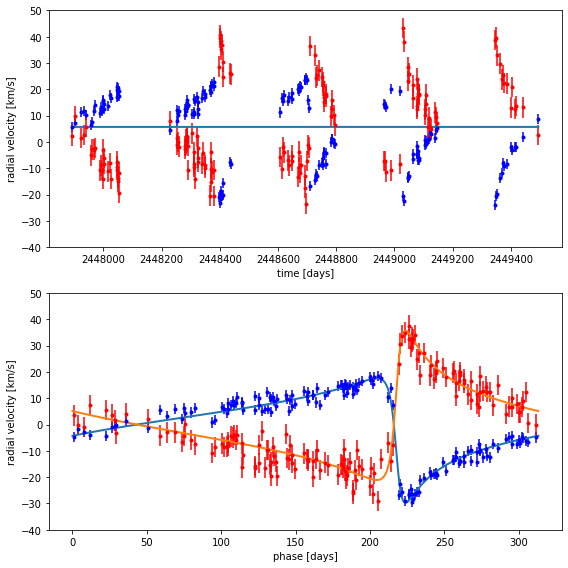

In [6]:
#  In the top plot, we’re looking at the RV observations as a function of time with the initial guess
# for the long-term trend overplotted in blue. In the lower panel, we plot the “folded” curve where 
# we have wrapped the observations onto the best-fit period and the prediction for a single overplotted
# in orange. If this doesn’t look good, try adjusting the initial guesses for the parameters and see if 
# you can get a better fit.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rva, yerr=rva_err, fmt=".b")
ax.plot(t, map_params["bkg"], color="C0", lw=2)
ax.errorbar(t, rvb, yerr=rvb_err, fmt=".r")
ax.set_ylim(-40, 50)
ax.set_ylabel("radial velocity [km/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rva - map_params["bkg"], yerr=rva_err, fmt=".b")
ax.plot(phase * period, map_params["rvphase_a"], color="C0", lw=2)
ax.errorbar(t % period, rvb - map_params["bkg"], yerr=rvb_err, fmt=".r")
ax.plot(phase * period, map_params["rvphase_b"], color="C1", lw=2)
ax.set_ylim(-40, 50)
ax.set_ylabel("radial velocity [km/s]")
ax.set_xlabel("phase [days]")

print('Gamma: '+str(np.median(map_params["bkg"])))

plt.tight_layout()

In [9]:
# Now let’s sample the posterior starting from our “maximum a posteriori” (MAP) estimate.

with model:
    trace = pm.sample(
        tune=8000,
        draws=4000,
        start=map_params,
        chains=2,
        cores=4,
        #initial_accept=0.8,
        target_accept=0.9,
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/home/sebauri/anaconda3/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:503: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [rvtrend, rv0, hk, phi, logP, logK2, logK1]


Sampling 2 chains for 8_000 tune and 4_000 draw iterations (16_000 + 8_000 draws total) took 92 seconds.
There were 828 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7983949092783155, but should be close to 0.9. Try to increase the number of tuning steps.
There were 583 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8314715329560716, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


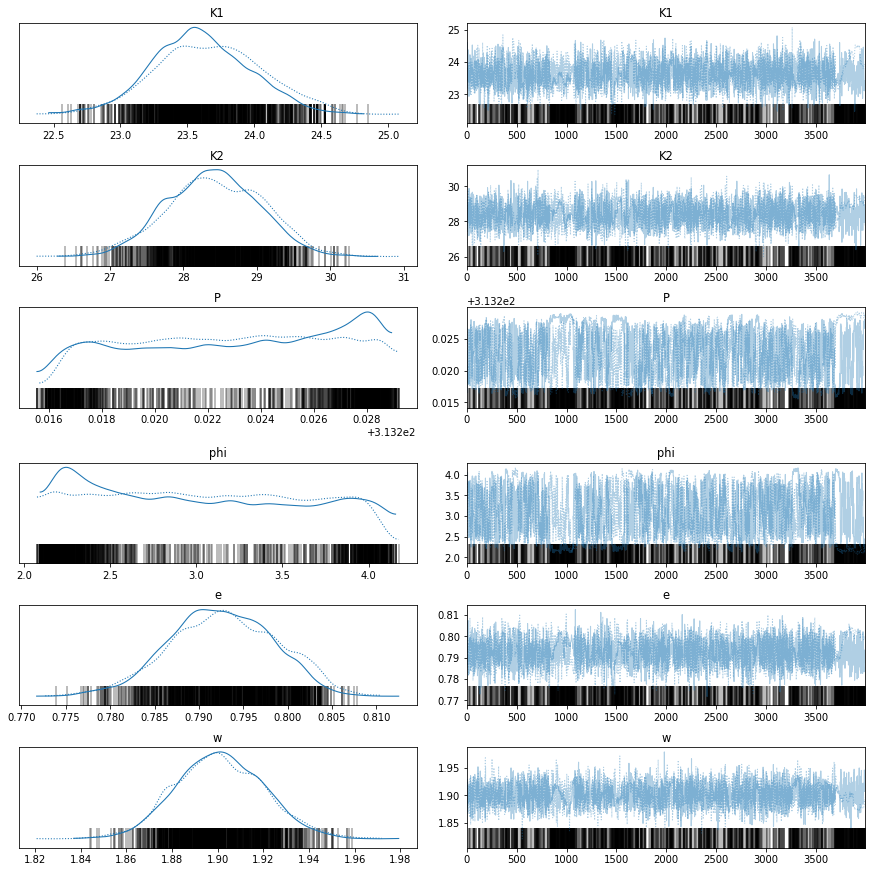

In [10]:
with model:
    _ = pm.traceplot(trace, var_names=["K1", "K2", "P", "phi", "e", "w"])

In [11]:
with model:
    summary = pm.summary(
        trace,
        var_names=["K1", "K2", "P", "phi", "e", "w", "rv0", "rvtrend"],
    )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
K1,23.635,0.384,22.894,24.346,0.017,0.012,499.0,492.0,527.0,805.0,1.01
K2,28.414,0.645,27.241,29.623,0.020,0.014,1007.0,1007.0,1050.0,3009.0,1.00
P,313.223,0.004,313.217,313.229,0.000,0.000,123.0,123.0,87.0,66.0,1.02
phi,3.054,0.595,2.133,4.011,0.054,0.038,124.0,124.0,88.0,71.0,1.02
e,0.793,0.006,0.782,0.804,0.000,0.000,432.0,429.0,434.0,741.0,1.01
w,1.901,0.020,1.865,1.937,0.001,0.000,1421.0,1421.0,1410.0,3177.0,1.00
rv0,-0.227,9.517,-17.373,18.941,0.255,0.181,1391.0,1391.0,1375.0,1843.0,1.00
rvtrend,0.001,0.001,-0.002,0.003,0.000,0.000,1391.0,1261.0,1376.0,1872.0,1.00


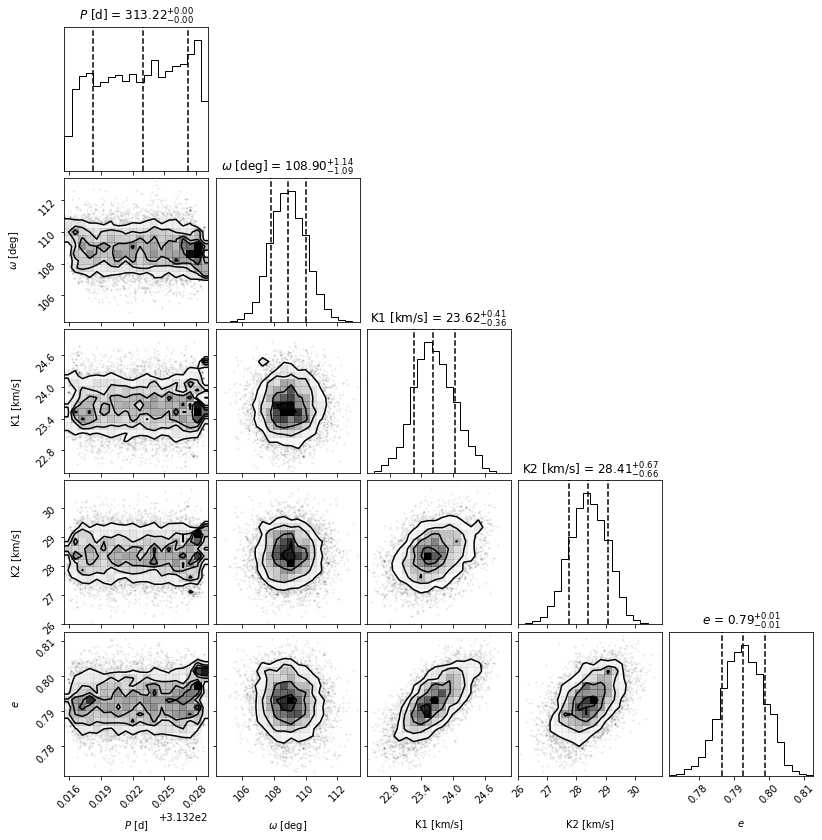

In [12]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["e"])
samples["$P$ [d]"] = trace["P"]
samples["$\omega$ [deg]"] = (trace["w"] / deg) % 360
samples["K1 [km/s]"] = (trace["K1"]) 
samples["K2 [km/s]"] = (trace["K2"])
samples["$e$"] = samples["e"]

del samples["e"]
_ = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True,
                  title_kwargs={"fontsize": 12})

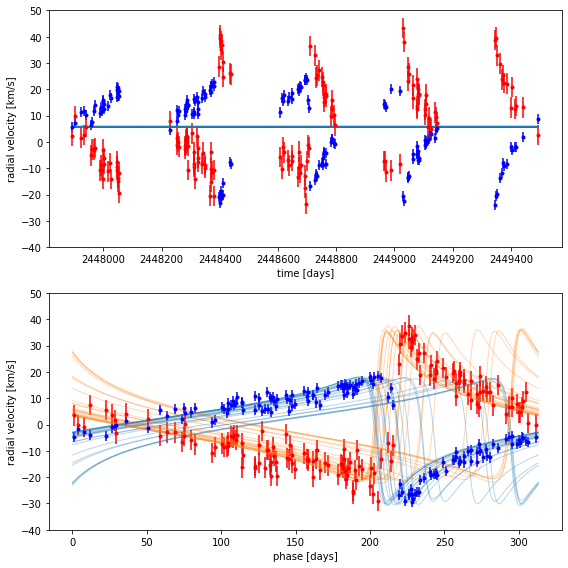

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rva, yerr=rva_err, fmt=".b")
ax.errorbar(t, rvb, yerr=rvb_err, fmt=".r")

ax.set_ylabel("radial velocity [km/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rva - map_params["bkg"], yerr=rva_err, fmt=".b")
ax.errorbar(t % period, rvb - map_params["bkg"], yerr=rvb_err, fmt=".r")

ax.set_ylabel("radial velocity [km/s]")
ax.set_xlabel("phase [days]")


for i in np.random.randint(len(trace) * trace.nchains, size=25):
    axes[0].plot(t, trace["bkg"][i], color="C0", lw=1, alpha=0.3)
    axes[1].plot(
        phase * period, trace["rvphase_a"][i], color="C0", lw=1, alpha=0.3
        )
    axes[1].plot(
        phase * period, trace["rvphase_b"][i], color="C1", lw=1, alpha=0.3
    )

axes[0].set_ylim(-40, 50)
axes[1].set_ylim(-40, 50)

plt.tight_layout()

In [14]:
# Still not well constrained, lets try now with a joint-fit (astrometry+RV)

# Read astrometry 
astrometry_elipse_B = pd.read_csv('HD98800B_astrometry.csv')

# The uncertainties in the astrometry from optical interferomtry should be represented wit an elipse error
# i.e PA, sigma_maj, sigma_min (see Gallenne et al. 2015). 
# For this example we will use semi major axis (sigma_maj) as a astrometry error (to be conservative).


t_astro = astrometry_elipse_B['MJD'].to_numpy()
astro_jds = t_astro + 2400000.5 # [Julian Date]
x = astrometry_elipse_B['x'].to_numpy()
x_err = astrometry_elipse_B['sigma_maj'].to_numpy()
y = astrometry_elipse_B['y'].to_numpy()
y_err = astrometry_elipse_B['sigma_maj'].to_numpy()

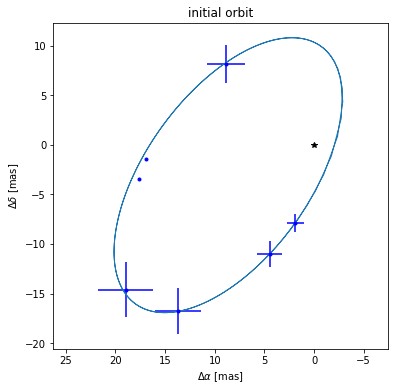

In [15]:
# Orbital elements from Boden et al. 2005
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.0233  # arcsec
parallax = 0.0237  # arcsec 
a = a_ang * au_to_R_sun / parallax
e = 0.7849
i = 66.8 * deg  # [rad]
omega = 289.6 * deg - np.pi  # omega_2, but we want omega_1
Omega = 337.4 * deg
P = 314.327   # days

#T0 = Time(1989.92, format="decimalyear")
#T0.format = "jd"
#T0 = T0.value  # [Julian Date]
T0 = 52481.34 + 2400000.5 # [Julian Date]


# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega
)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t_fine = np.linspace(T0 - P, T0 + P, num=200)  # days
rho, theta = theano.function([], orbit.get_relative_angles(t_fine, parallax))()

#y_model, x_model, z_model = theano.function([], orbit.get_relative_position(astro_jds, parallax))()

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(6, 6))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys*1000, xs*1000, color="C0", lw=1)



ax.errorbar(x, y, yerr=y_err, xerr=x_err, fmt=".b")
#ax.scatter(x_model*1000,y_model*1000)

ax.set_ylabel(r"$\Delta \delta$ [mas]")
ax.set_xlabel(r"$\Delta \alpha$ [mas]")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")


plt.show()

In [16]:
#Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        a_ang = pm.Uniform("a_ang", 0.005, 0.1, testval=0.0233)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 300 days,
        # so we'll set a broad prior on logP
        logP = pm.Normal(
            "logP", mu=np.log(310), sd=np.log(10), testval=np.log(314.327)
        )
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = 289.6 * deg - np.pi
        Omega0 = 337.6 * deg
        p = Angle("p", testval=0.5 * (Omega0 + omega0))
        m = Angle("m", testval=0.5 * (Omega0 - omega0))
        omega = pm.Deterministic("omega", p - m)
        Omega = pm.Deterministic("Omega", p + m)
        #omega = pm.Uniform("omega", 0, 2*np.pi, testval=omega0)
        #Omega = pm.Uniform("Omega", 0, 2*np.pi, testval=Omega0)
        
        

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        T0 = 52481.34 + 2400000.5 # [Julian Date]
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2 * np.pi))

        # Geometric uniform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1, testval= np.cos(66.8 * deg)
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.7849)
        
        # RV Parameters
        logK1 = pm.Uniform(
        "logK1",
        lower=0,
        upper=np.log(100),
        testval=np.log(0.5 * (np.max(rva) - np.min(rva))),
        )
        
        logK2 = pm.Uniform(
        "logK2",
        lower=0,
        upper=np.log(100),
        testval=np.log(0.5 * (np.max(rvb) - np.min(rvb))),
        )
        
        rv0 = pm.Normal("rv0", mu=0.0, sd=10.0, testval=0.0)
        rvtrend = pm.Normal("rvtrend", mu=0.0, sd=10.0, testval=0.0)
    

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a= a * au_to_R_sun,
            t_periastron= tperi,
            period= P,
            incl= incl,
            ecc= ecc,
            omega= omega,
            Omega= Omega,
        )
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)
            
        #Primary
        K1 = pm.Deterministic("K1", tt.exp(logK1))
        
        # Secondary
        K2 = pm.Deterministic("K2", tt.exp(logK2))
        
        # The RV model
        bkg = pm.Deterministic("bkg", rv0 + rvtrend * t / 365.25)
        
        #Primary
        rvmodel_a = pm.Deterministic(
        "rvmodel_a", orbit.get_radial_velocity(t,K1) + bkg
        )
        
        #Secondary
        rvmodel_b = pm.Deterministic(
        "rvmodel_b", bkg - orbit.get_radial_velocity(t,K2)
        )
        
        # Condition on the observations
        pm.Normal("obs_a", mu=rvmodel_a, sd=rva_err, observed=rva)
        pm.Normal("obs_b", mu=rvmodel_b, sd=rvb_err, observed=rvb)
        

        # Compute the model in x,y
        y_model, x_model, z_model = orbit.get_relative_position(astro_jds, plx)
        pm.Deterministic("x_model", x_model)
        pm.Deterministic("y_model", y_model)
        
        # define the likelihood function, e.g., a Gaussian on both x and y
        pm.Normal("x_obs", mu=x_model, sd=x_err/1000, observed=x/1000)
        pm.Normal("y_obs", mu=y_model, sd=y_err/1000, observed=y/1000)
        
        
        # Set up predicted orbits for later plotting
        y_dense, x_dense, z_dense = orbit.get_relative_position(t_fine, plx)
        x_save = pm.Deterministic("x_save", x_dense)
        y_save = pm.Deterministic("y_save", y_dense)
        
        #t_fine_rv =  np.linspace(tperi, tperi+P, num=500)
        va_dense = orbit.get_radial_velocity(t,K1)
        vb_dense = orbit.get_radial_velocity(t,K2)
        
        va_save = pm.Deterministic("va_save",va_dense)
        vb_save = pm.Deterministic("vb_save",vb_dense)
        
        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[logK1, logK2, bkg, phase, logP, ecc])
        map_soln = xo.optimize(map_soln, vars=[omega, Omega, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)


    return model, map_soln

model, map_soln = get_model() 

#model, map_soln = get_model(parallax=[23.3,2.5]) # With hipparcos parallax



optimizing logp for variables: [ecc, logP, phase, rv0, rvtrend, logK2, logK1]


message: Desired error not necessarily achieved due to precision loss.
logp: -46410.390317825964 -> -875.7634179531527
optimizing logp for variables: [ecc, p, m]


message: Optimization terminated successfully.
logp: -875.7634179531527 -> -687.3056530468764
optimizing logp for variables: [phase, a_ang, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -687.3056530468764 -> -685.3849804501231
optimizing logp for variables: [rvtrend, rv0, logK2, logK1, ecc, cos_incl, phase, m, p, logP, a_ang]


message: Desired error not necessarily achieved due to precision loss.
logp: -685.3849804501239 -> -602.5742433761038


314.6505811799783


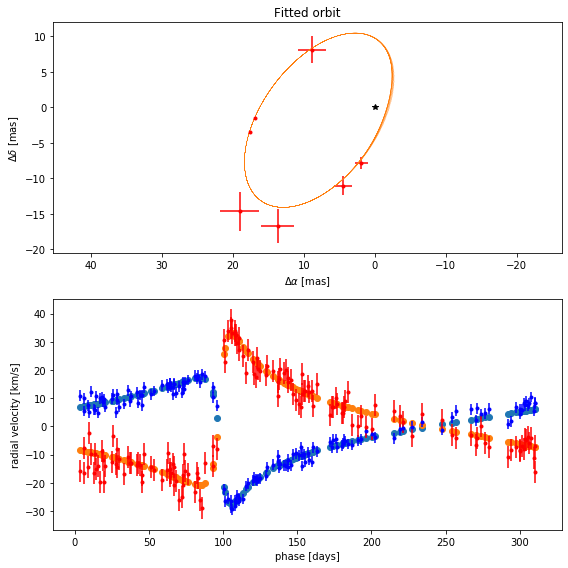

In [17]:
period = map_soln["P"]

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

ax = axes[0]


ax.set_ylabel(r"$\Delta \delta$ [mas]")
ax.errorbar(x, y, yerr=y_err, xerr=x_err, fmt=".r")
ax.plot(map_soln["x_save"]*1000, map_soln["y_save"]*1000, color = "C1", lw=0.1)

ax.set_xlabel(r"$\Delta \alpha$ [mas]")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("Fitted orbit")

ax = axes[1]
ax.errorbar(t % period, rva - map_soln["bkg"], yerr=rva_err, fmt=".b")
ax.errorbar(t % period, rvb - map_soln["bkg"], yerr=rvb_err, fmt=".r")
ax.scatter(t % period, map_soln["va_save"], color = "C0", marker='o')
ax.scatter(t % period, -map_soln["vb_save"], color = "C1", marker='o')

#q = np.percentile(trace["va_save"], [16, 84], axis=0)
#ax.fill_between(t_fine % period, q[0], q[1], color="C0", alpha=0.7, lw=0)

#q = np.percentile(trace["vb_save"], [16, 84], axis=0)
#ax.fill_between(t_fine % period, -q[0], -q[1], color="C1", alpha=0.7, lw=0)

ax.set_ylabel("radial velocity [km/s]")
ax.set_xlabel("phase [days]")

#for i in np.random.randint(len(trace) * trace.nchains, size=25):
 #   axes[0].plot(t, trace["bkg"][i], color="C0", lw=1, alpha=0.3)




#axes[0].set_ylim(-40, 50)
#axes[1].set_ylim(-40, 50)
print(period)

plt.tight_layout()

In [18]:
# Run MCMC sampler
with model:
    trace = pm.sample(
        tune=8000,
        draws=4000,
        start=map_soln,
        cores=2,
        chains=2,
        init="adapt_full",
        target_accept=0.9,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/home/sebauri/anaconda3/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:503: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rvtrend, rv0, logK2, logK1, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 2 chains for 8_000 tune and 4_000 draw iterations (16_000 + 8_000 draws total) took 346 seconds.
There were 207 divergences after tuning. Increase `target_accept` or reparameterize.
There were 360 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [19]:
# Then we can look at some summaries of the trace and the constraints on some of the key parameters:
with model:
    summary = pm.summary(
        trace,
        varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"],
    )
summary

/home/sebauri/anaconda3/lib/python3.7/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,314.683,0.123,314.457,314.914,0.004,0.003,776.0,775.0,850.0,643.0,1.0
tperi,2452485.740,1.570,2452482.922,2452488.763,0.057,0.041,750.0,749.0,837.0,629.0,1.0
a_ang,0.020,0.001,0.019,0.022,0.000,0.000,782.0,782.0,938.0,555.0,1.0
omega,-4.414,0.015,-4.443,-4.386,0.000,0.000,1005.0,1005.0,1043.0,666.0,1.0
Omega,-0.384,0.033,-0.447,-0.323,0.001,0.001,931.0,931.0,978.0,754.0,1.0
incl,1.124,0.022,1.083,1.163,0.001,0.001,630.0,630.0,830.0,556.0,1.0
ecc,0.776,0.006,0.765,0.787,0.000,0.000,3055.0,3045.0,3012.0,3595.0,1.0


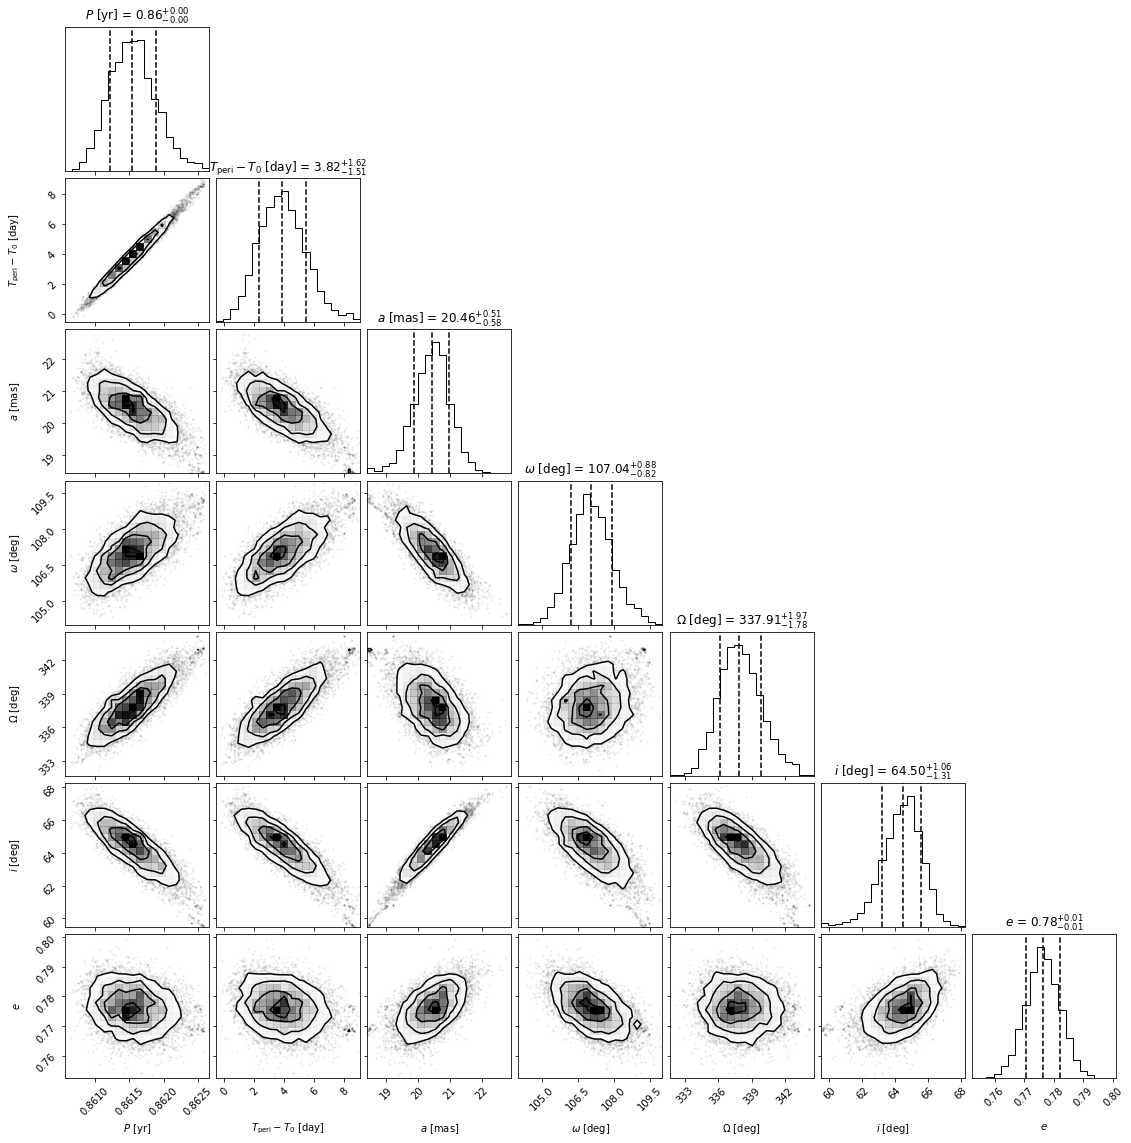

In [20]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [mas]"] = trace["a_ang"] * 1000
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
#samples["$plx [mas]$"] = trace["m_plx"]
samples["$e$"] = samples["ecc"]

del samples["ecc"]
_ = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True,
                  title_kwargs={"fontsize": 12})

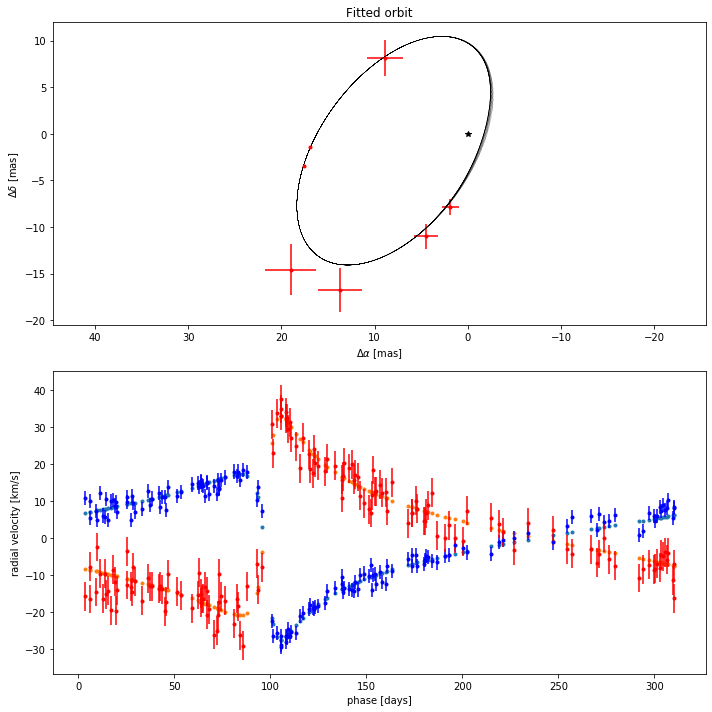

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

ax = axes[0]


ax.set_ylabel(r"$\Delta \delta$ [mas]")
ax.errorbar(x, y, yerr=y_err, xerr=x_err, fmt=".r")
ax.plot(map_soln["x_save"]*1000, map_soln["y_save"]*1000, color = "k", lw=0.1)

ax.set_xlabel(r"$\Delta \alpha$ [mas]")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("Fitted orbit")

ax = axes[1]
ax.errorbar(t % period, rva - map_soln["bkg"], yerr=rva_err, fmt=".b")
ax.errorbar(t % period, rvb - map_soln["bkg"], yerr=rvb_err, fmt=".r")
ax.scatter(t%period, map_soln["va_save"], color = "C0", marker='.')
ax.scatter(t%period, -map_soln["vb_save"], color = "C1", marker='.')

#q = np.percentile(trace["va_save"], [16, 84], axis=0)
#ax.fill_between(t % period, q[0], q[1], color="C0", alpha=0.7, lw=0)

#q = np.percentile(trace["vb_save"], [16, 84], axis=0)
#ax.fill_between(t % period, -q[0], -q[1], color="C1", alpha=0.7, lw=0)

ax.set_ylabel("radial velocity [km/s]")
ax.set_xlabel("phase [days]")

#for i in np.random.randint(len(trace) * trace.nchains, size=25):
 #   axes[0].plot(t, trace["bkg"][i], color="C0", lw=1, alpha=0.3)




#axes[0].set_ylim(-40, 50)
#axes[1].set_ylim(-40, 50)

plt.tight_layout()